# Convolution NN for first break picking

First-break picking is the task of determining, given a set of raw seismic traces, the onsets of the first signal arrivals as accurately as possible. The accurate determination of the first arrivals onset first-break times is needed for calculating the static corrections, a fundamental stage of seismic data processing.

* [Datasets](#Datasets)
* [Model architecture](#Model-Architecture)
* [Training](#Training)
* [Inference](#Inference)
* [Running time](#Running-time)
* [Model evaluation](#Model-evaluation)
* [Criticism](#Criticism)
* [Conclusion](#Conclusion)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.append('../../picking/SeismicPro/')

from seismicpro.batchflow import B, V, W
from seismicpro.batchflow.models.torch import UNet
from seismicpro.src import SeismicDataset, FieldIndex, TraceIndex, seismic_plot
from seismicpro.models.metrics import PickingMetrics

In [2]:
markup_path = '/notebooks/picking/data/targets.csv'
path_raw = '/notebooks/picking/data/traces.sgy'

Index field records with FB time as a separate column:

In [3]:
# write FiledIndex with name : 'raw', do not forget path_raw and markup_path
index = # your code here

Load one seismogram and coresponding picking.

In [4]:
batch = (SeismicDataset(index).next_batch(batch_size=1)
        .load(components='raw', fmt='segy')
        .load(components='markup', fmt='picks'))

Draw the whole seismogram and 10 zoomed traces with labeled picking too see the pattern of fb picking.

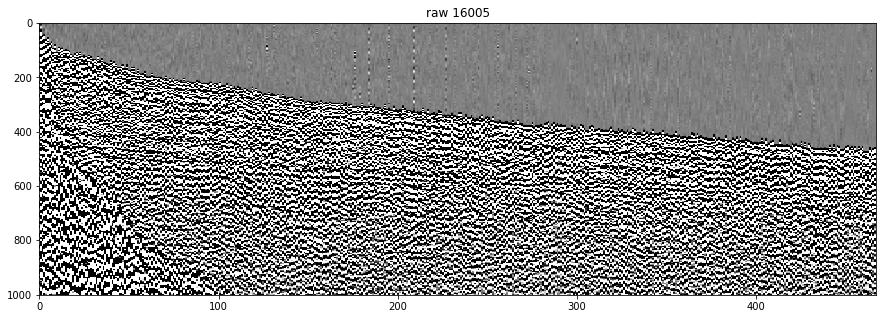

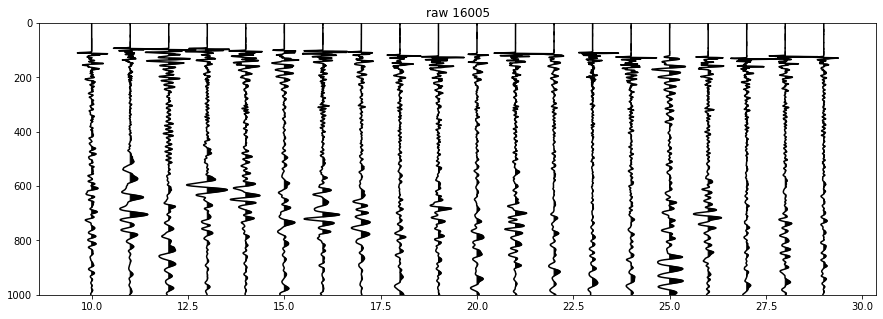

In [5]:
cv = 1000
(batch.seismic_plot('raw', index.indices[0], cmap='gray', figsize=(15,5), vmax=cv, vmin=-cv)
      .seismic_plot('raw', index.indices[0], cmap='gray', figsize=(15,5), vmax=cv, vmin=-cv,
                    wiggle=True, xlim=(10, 30), ylim=(0,1000), std=0.1))

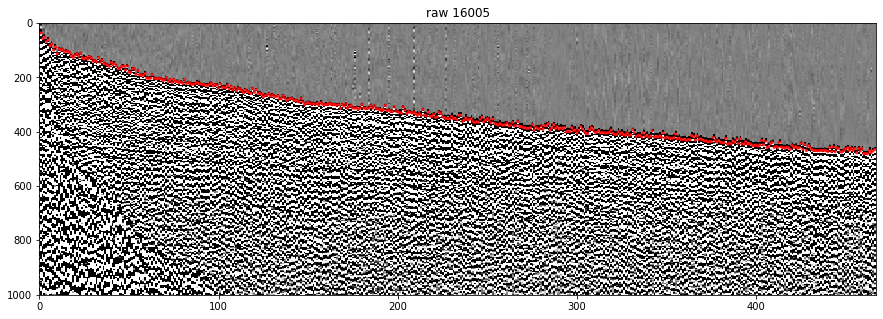

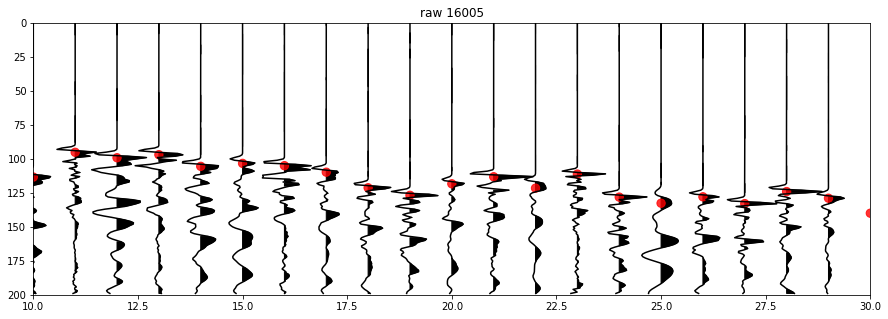

In [6]:
cv = 1000
(batch.seismic_plot('raw', index.indices[0], src_picking='markup', cmap='gray',
                     figsize=(15,5), vmax=cv, vmin=-cv, s=5, scatter_color='r')
      .seismic_plot('raw', index.indices[0], src_picking='markup', cmap='gray',
                    figsize=(15,5), vmax=cv, vmin=-cv, s=70, scatter_color='r',
                    wiggle=True, xlim=(10, 30), ylim=(0,200), std=0.1))

In [ ]:
# create subset with 140 elements from 0 to 140
train_index = #

# create SeismicDataset with TraceIndex
train_data = #

In [8]:
# create subset with indices from 140 to the end
test_index = #

# create SeismicDataset with TraceIndex
test_data = #

## Model Architecture

In [11]:
config = {
    'inputs': {'targets': dict(classes=2)},
    # define encoder block with 5 blocks. Write number of filters for each block and kernel size for all blocks
    # we suggest to use number of filters from 8 to 128 with kernel size 5.
    # Name for number of filters - 'filters'
    # for kernel_size - 'kernel_size'
    'body/encoder/blocks': #
    # define decoder block with 5 blocks.
    # suggestion - from 128 to 8
    'body/decoder/blocks': #
    
    # define number of filters for embedding. (256 as suggestion)
    'body/embedding/filters': #
    
    'output': {'predicted': ['proba']},
    
    # create optimizer (suggestion adam with learning rate you like (0.001 for example)) 
    'optimizer': #
    'device': 'gpu',
}

In [ ]:
train_pipeline = (train_data.p
                      #Here you have to write the following actions:
                      #1. Initialize model with 4 arguments: 
                          #1.1. Just write 'dynamic'
                          #1.2. Write model we use (UNet)
                          #1.3. Model name (write name you like)
                          #1.4. Config
                      #2. Load 'raw' component with format 'segy'
                      #3. Load 'markup' component with format 'picks'
                      #4. Standardize raw component
                      #5. Initialize variable to measure loss. With initialize value - list
                      .picking_to_mask(src='markup', dst='mask', src_traces='raw')
                      .apply_transform_all(src='raw', dst='raw', func=lambda x: np.stack(x))
                      .apply_transform_all(src='mask', dst='mask', func=lambda x: np.stack(x))
                      #6.Here another action for train model with following arguments:
                          #6.1. Model name. Should be the same as 1.3.
                          #6.2. Model inputs - B('raw')
                          #6.3. Model answers - B('mask')
                          #6.4. Write fetches to save loss history.
                          #6.5. Write save_to argument with mode 'a'. argument name should be the same as variable name.
                      .run_later(64, n_iters=2000, drop_last=True, shuffle=True, bar=True))

In [13]:
#Run train_pipeline!
#code here 

100%|██████████| 2000/2000 [01:23<00:00, 23.93it/s]


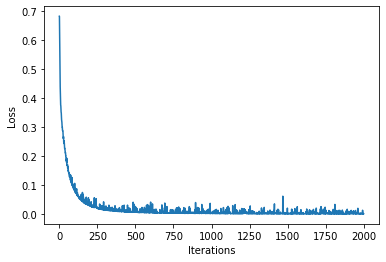

In [14]:
# let's get variable value from train_pipeline. Use get_variable function for it.
loss = #
plt.xlabel("Iterations"), plt.ylabel("Loss")
plt.plot(loss)

## Validation

In [15]:
test_pipeline = (test_data.p
                 #Here you have to write the following actions:
                 #1. Import model wh arguments:
                     #1.1. model name (same as 1.3. from train_pipeline)
                     #1.2. Pipeline from which we want to import model
                 #2. Initilize variable for saving "true" values with list as default value
                 #3. Initilize variable for saving "traces" values with list as default value
                 #4. Initilize variable for saving model "predictions" values with list as default value
                 #5. As before load raw data
                 #6. As before load markup data
                 #7. Standardize data as before
                      .picking_to_mask(src='markup', dst='mask', src_traces='raw')
                      .apply_transform_all(src='raw', dst='raw', func=lambda x: np.stack(x))
                      .apply_transform_all(src='mask', dst='mask', func=lambda x: np.stack(x))               
                      .add_components(components='predictions')
                 #8. Do a model prediction by using predict_model with following arguments:
                     #8.1. model name as before
                     #8.2. data to predict (raw as before)
                     #8.3. fetches - predicted_proba
                     #8.4. save to variable from 4. with mode 'a'
                 #9. Update variable 2. with value from B('mask')
                 #10. Update variable 3. with value from B('raw')
                 #11. Update variable 4. with value from B('predictions') 
                      .run_later(1000, n_epochs=1, drop_last=False, shuffle=False, bar=True))

In [16]:
#Run test_pipeline!
#code here 

100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


Arrange results:

In [17]:
pred_proba = np.concatenate(test_pipeline.get_variable('predictions'))
true = np.argmax(np.vstack(test_pipeline.get_variable('true')), axis=1)
traces = np.vstack(np.concatenate(test_pipeline.get_variable('traces')))

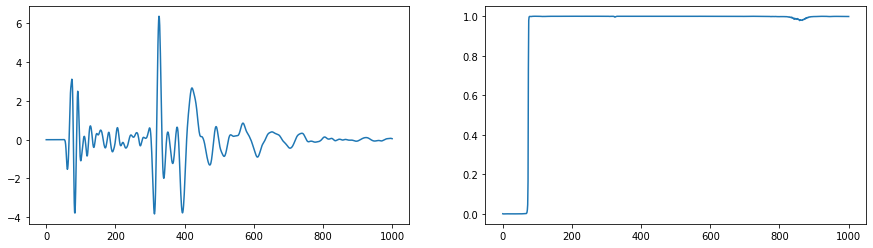

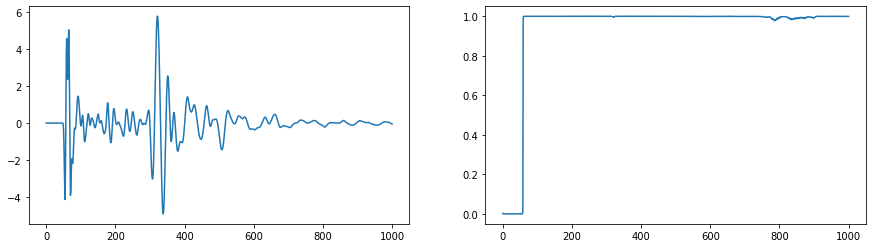

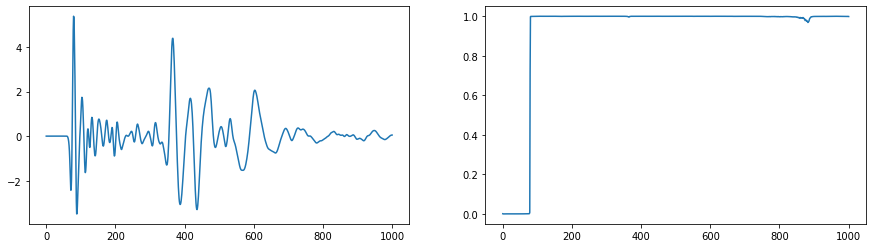

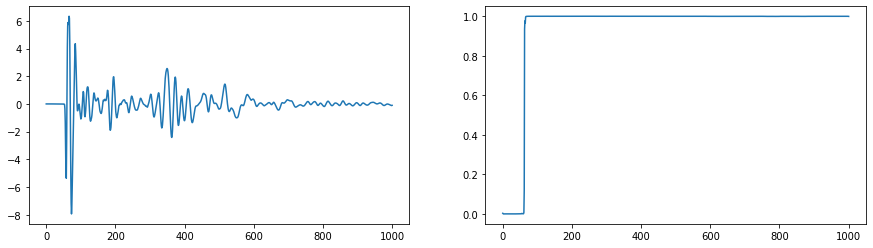

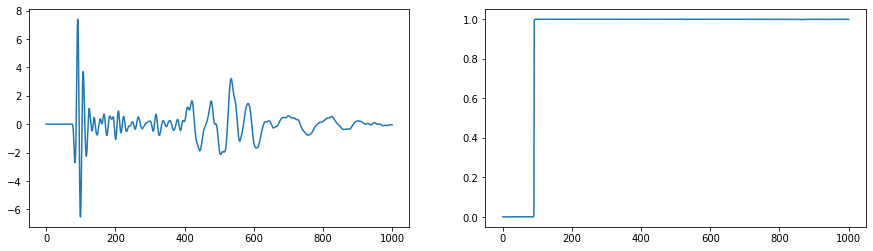

In [18]:
for mask, trace in list(zip(pred_proba, traces))[:5]:
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))
    ax[0].plot(trace)
    ax[1].plot(mask[1])

In [19]:
from seismicpro.src.utils import massive_block

In [20]:
def mask_to_sample(pred_proba):
    mask = np.argmax(pred_proba, axis=1)
    sample = np.argmax(mask, axis=1)
    ##### sample = ...
    return sample

In [21]:
pred = mask_to_sample(pred_proba)

#### MAE metrics.

Mean absolute error.

In [22]:
print('MAE on validation: {0:.3f}'.format(np.mean(abs(true - pred), dtype=np.float)))

MAE on validation: 0.196


#### Visual estimation.

Draw the seismogram with predictions(blue) and targets(red).

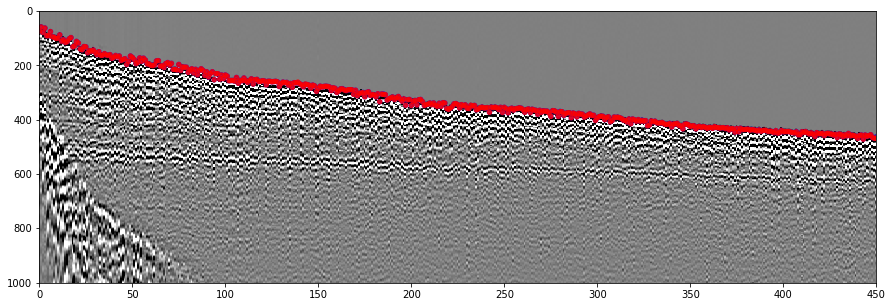

In [23]:
cv = 1
pts_pred = (range(len(pred)), pred)
pts_true = (range(len(true)), true)

seismic_plot(traces, cmap='gray', vmin=-cv, vmax=cv, pts=[pts_pred, pts_true], s=20,
             scatter_color=['b', 'r'], figsize=(15,5), xlim=(0, 450))

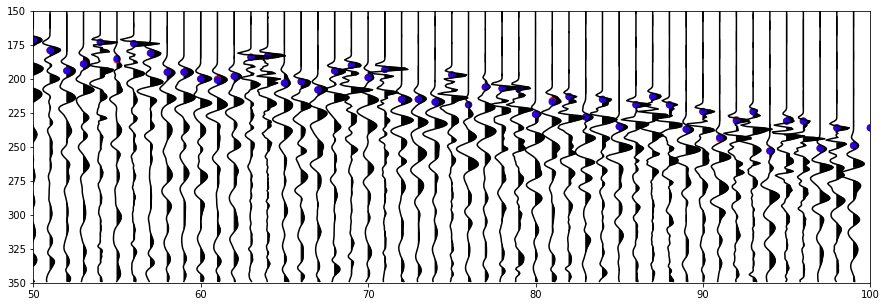

In [24]:
std = 0.1
xlim = (50, 100)
ylim = (150, 350)

pts_pred = (range(len(pred)), pred)
pts_true = (range(len(true)), true)

seismic_plot(traces, cmap='gray', vmin=-cv, vmax=cv, pts=[pts_pred, pts_true], s=40,
             scatter_color=['r', 'b'], figsize=(15,5),
             xlim=xlim, ylim=ylim, wiggle=True, std=std)